# 1. Setup

## 1.1 Overview
This section establishes the foundation for **k-NN student dropout prediction** through careful data preparation and setup.

* **Environment setup**
  * Imports scientific stack (`numpy`, `pandas`, `sklearn`) plus custom `Tools` utilities
  * **Fixed random seeds** (`42`) ensure identical results across runs – critical for model comparison
  
* **Configuration management**
  * Centralised `config.toml` stores hyperparameters and feature definitions
  * **Key benefit**: experiment variations require only config changes, not code edits

* **Dataset ingestion**
  * **UCI "Predict Students Dropout and Academic Success"** dataset (4,424 students × 37 features)
  * Immediate shape validation catches loading issues early

* **Binary target creation**
  * **Strategic simplification**: `Dropout` → 0, `Enrolled/Graduate` → 1
  * **Rationale**: institutions care about identifying withdrawal risk, not distinguishing graduates from current students
  * **Result**: 68% continuation vs 32% withdrawal (manageable imbalance for k-NN)

* **Validation checkpoint**
  * Final dimensions: 4,424 × 38 (added `target_binary`)
  * **Status confirmation** makes any data pipeline issues immediately visible

**Outcome**: Clean, reproducible dataset ready for k-NN feature engineering, with binary classification optimally aligned to institutional early-intervention goals.

## 1.2 Libraries Import

In [255]:
# Project utilities
from tools import Tools

# Standard library
import random

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn – data prep & modelling
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# scikit-learn – evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)


In [256]:
# Set random seeds for full reproducibility
np.random.seed(42)
random.seed(42)
print("✅ Random seeds set for reproducibility")

✅ Random seeds set for reproducibility


## 1.3 Invoke Classes

In [257]:
tools = Tools()

## 1.4 Load Configuration

In [258]:
config = tools.load_toml_file("config.toml")
knn_config = config.get('k-NN_model', {})
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> ✅ SUCCESS!: Loaded configuration NUMBER OF KEYS: 6

## 1.5 Load the dataset

In [259]:
# Open dataset
# Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].
df_dataset = tools.load_dataset(file_name='dataset_raw.csv')
df_dataset.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.6 Apply Target Binary Transformation

In [260]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
df_dataset['target_binary'].value_counts()

target_binary
1    3003
0    1421
Name: count, dtype: int64

## 1.7 Data Shape Check

In [261]:
shape = df_dataset.shape
tools.print_message('success', 'Dataset loaded', format_dict={'rows': shape[0], 'columns': shape[1]})

>>> ✅ SUCCESS!: Dataset loaded ROWS: 4424, COLUMNS: 38

# 2. Feature Selection

## 2.1 Overview
This section implements **strategic feature selection** to optimise the dataset for k-NN performance, reducing 36 features to 10 carefully chosen predictors.

* **Data leakage prevention**
  * **Removes all second semester features** – students who withdraw early show zeros, creating perfect but useless predictors
  * **Critical for early intervention**: model must predict withdrawals using only first-semester data

* **Noise reduction**
  * **Severely imbalanced features** (>97% in one category): nationality, educational special needs, international status
  * **Weak economic predictors** (correlation <0.05): unemployment, inflation, GDP rates
  * **Redundant indicators**: displaced status, daytime/evening attendance (zero mutual information)

* **Multicollinearity resolution**
  * **High VIF removal** (>10): first semester enrolled/credited/approved units
  * **Keeps only grades** as academic performance indicator (VIF: 4.98)
  * **Why this matters**: redundant features dominate k-NN distance calculations

* **High-cardinality feature engineering**
  * **Parents' qualifications** (58 categories) → `parental_higher_education` (binary)
  * **Parents' occupations** (92 categories) → `parental_professional_occupation` (binary)
  * **Prevents curse of dimensionality**: 150+ one-hot encoded features → 2 meaningful indicators

* **Final optimisation**
  * **Strategic removal**: marital status, gender, debtor status (weaker predictors)
  * **Keeps strongest signals**: tuition fees, scholarship status, course context, academic performance

**Outcome**: Focused 10-feature dataset optimised for k-NN's distance-based similarity calculations, with data leakage eliminated and curse of dimensionality avoided.

## 2.2 Features to Remove

In [262]:
# Severe class imbalance makes these features uninformative
uninformative_categorical = [
    'nationality',                    # 97.5% Portuguese - no variation
    'educational_special_needs',      # 98.9% no special needs - no variation
    'international',                  # 97.5% domestic - no variation
    'displaced',                      # Zero mutual information with target
    'daytime_evening_attendance'      # Zero mutual information with target
]

# Very weak correlation with target variable makes these unhelpful
weak_economic_features = [
    'unemployment_rate',              # -0.03 correlation - essentially no relationship
    'inflation_rate',                 # 0.02 correlation - essentially no relationship
    'gdp'                            # 0.05 correlation - essentially no relationship
]

# Data leakage - using information that only exists after the outcome has occurred
second_semester_remove = [
    'curricular_units_2nd_sem_grade',           # VIF 5.46 but still data leakage
    'curricular_units_2nd_sem_enrolled',        # VIF 16.42
    'curricular_units_2nd_sem_credited',        # VIF 12.39
    'curricular_units_2nd_sem_approved',        # VIF 10.14
    'curricular_units_2nd_sem_evaluations',     # VIF 3.33
    'curricular_units_2nd_sem_without_evaluations'  # VIF 1.57
]

# Remove HIGH VIF 1st semester features (>10) to fix multicollinearity
first_semester_high_vif_remove = [
    'curricular_units_1st_sem_enrolled',        # VIF 23.49 (WORST)
    'curricular_units_1st_sem_credited',        # VIF 15.57 
    'curricular_units_1st_sem_approved'         # VIF 12.63
]

# Features to remove for final k-NN model - keeping only top 10 predictive features
features_to_remove_final = [
    'marital_status',                           # Weaker categorical predictor
    'previous_qualification',                   # Weaker categorical predictor  
    'previous_qualification_grade',             # Weak correlation (0.08)
    'debtor',                                  # Redundant with tuition_fees_up_to_date
    'gender',                                  # Weaker categorical predictor
    'curricular_units_1st_sem_evaluations',   # Moderate but less critical
    'curricular_units_1st_sem_without_evaluations',  # Moderate but less critical

    'target'                                 # Old target variable (replaced with target_binary) - no longer needed
]

# Combine all features to drop
drop_columns = (uninformative_categorical + weak_economic_features + 
                second_semester_remove + first_semester_high_vif_remove + 
                features_to_remove_final)

df_dataset.drop(columns=drop_columns, inplace=True)

## 2.3 Reduce High Cardinality Features

In [263]:
# Check if parental features still exist in dataset
parental_features = ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']
existing_features = [f for f in parental_features if f in df_dataset.columns]
print(f"Remaining parental features: {existing_features}")

Remaining parental features: ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']


In [264]:
# To reduce the number of categories in the parental qualification and occupation features, we will group them into broader categories.
def create_parental_higher_ed(df, config):
    """
    Creates binary indicator for parental higher education.
    Returns 1 if at least one parent has higher education, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    higher_ed_codes = parental_config.get('higher_education_codes', [])
    
    if not higher_ed_codes:
        raise ValueError("Higher education codes not found in configuration")
    
    print(f"Using {len(higher_ed_codes)} higher education codes from config")
    
    mother_higher_ed = df['mothers_qualification'].isin(higher_ed_codes)
    father_higher_ed = df['fathers_qualification'].isin(higher_ed_codes)
    
    # At least one parent has higher education
    df['parental_higher_education'] = (mother_higher_ed | father_higher_ed).astype(int)
    df = df.drop(columns=['mothers_qualification', 'fathers_qualification'])
    
    return df

# Usage:
df_dataset = create_parental_higher_ed(df_dataset, config)
df_dataset.parental_higher_education.value_counts()

Using 11 higher education codes from config


parental_higher_education
0    3616
1     808
Name: count, dtype: int64

In [265]:
def create_parental_professional_occupation(df, config):
    """
    Creates binary indicator for parental professional occupation.
    Returns 1 if at least one parent has professional/managerial role, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    professional_codes = parental_config.get('professional_occupation_codes', [])
    
    if not professional_codes:
        raise ValueError("Professional occupation codes not found in configuration")
    
    print(f"Using {len(professional_codes)} professional occupation codes from config")
    
    mother_professional = df['mothers_occupation'].isin(professional_codes)
    father_professional = df['fathers_occupation'].isin(professional_codes)
    
    # At least one parent has professional occupation
    df['parental_professional_occupation'] = (mother_professional | father_professional).astype(int)
    df = df.drop(columns=['mothers_occupation', 'fathers_occupation'])
    
    return df

# Usage:
df_dataset = create_parental_professional_occupation(df_dataset, config)
df_dataset.parental_professional_occupation.value_counts()

Using 15 professional occupation codes from config


parental_professional_occupation
0    3270
1    1154
Name: count, dtype: int64

In [266]:
print(f"Dataset shape after parental feature engineering: {df_dataset.shape}")
print(f"Remaining features: {df_dataset.columns.tolist()}")

Dataset shape after parental feature engineering: (4424, 11)
Remaining features: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'target_binary', 'parental_higher_education', 'parental_professional_occupation']


In [267]:
# Final feature count verification
print(f"Features before target removal: {len(df_dataset.columns)}")
print(f"Features after removing target_binary: {len(df_dataset.columns) - 1}")
print(f"Final features for k-NN: {[col for col in df_dataset.columns if col != 'target_binary']}")

Features before target removal: 11
Features after removing target_binary: 10
Final features for k-NN: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation']


# 3. Data Splitting

In [268]:
def perform_train_test_split(df_dataset, train_size=0.8, random_state=42):
    """
    Split dataset into training and test sets with stratification.
    """
    X = df_dataset.drop('target_binary', axis=1)
    y = df_dataset['target_binary']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state, stratify=y
    )

    print(f'Training: {len(X_train)}, Test: {len(X_test)}')
    print(f'Training class distribution: {y_train.value_counts().to_dict()}')
    print(f'Test class distribution: {y_test.value_counts().to_dict()}')
    
    return X_train, X_test, y_train, y_test

# Perform final train-test split
X_train, X_test, y_train, y_test = perform_train_test_split(df_dataset)

Training: 3539, Test: 885
Training class distribution: {1: 2402, 0: 1137}
Test class distribution: {1: 601, 0: 284}


# 4. Feature Engineering (Post-Split)

In [269]:

def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col, target_col='target_binary'):
    """
    Calculate historical withdrawal rate for each category using training data only.
    Returns a mapping dictionary and a summary dataframe.
    """
    train_df = X_train.copy()
    train_df[target_col] = y_train
    
    withdrawal_rates = train_df.groupby(categorical_col)[target_col].agg(['count', 'sum'])
    withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
    withdrawal_rates['continuation_rate'] = withdrawal_rates['sum'] / withdrawal_rates['count']
    
    rate_mapping = withdrawal_rates['withdrawal_rate'].to_dict()
    
    summary_df = withdrawal_rates[['count', 'withdrawal_rate', 'continuation_rate']].copy()
    summary_df.columns = ['Students', 'Withdrawal_Rate', 'Continuation_Rate']
    summary_df = summary_df.round(3)
    summary_df = summary_df.sort_values('Withdrawal_Rate', ascending=False)
    
    return rate_mapping, summary_df


In [270]:

def apply_withdrawal_rate_encoding(X_train, X_test, y_train):
    """
    Apply withdrawal rate encoding to categorical features using training-derived rates.
    """
    # Calculate rates from training data only
    course_rates, course_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
    application_mode_rates, app_mode_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
    
    print("Course Withdrawal Rates (Training Data Only):")
    display(course_summary.head(10))
    print("\nApplication Mode Withdrawal Rates (Training Data Only):")
    display(app_mode_summary)
    
    # Apply to training data
    X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
    X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)
    
    # Apply to test data using training-derived mappings
    X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
    X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)
    
    # Handle test categories not seen in training
    overall_withdrawal_rate = 1 - y_train.mean()
    X_test = X_test.fillna({
        'course_withdrawal_rate': overall_withdrawal_rate, 
        'application_mode_withdrawal_rate': overall_withdrawal_rate
    })
    
    # Drop original categorical columns
    X_train = X_train.drop(columns=['course', 'application_mode'])
    X_test = X_test.drop(columns=['course', 'application_mode'])
    
    print(f"\nDataset shape after withdrawal rate encoding:")
    print(f"Training: {X_train.shape}, Test: {X_test.shape}")
    print(f"Features: {X_train.columns.tolist()}")
    
    return X_train, X_test

X_train, X_test = apply_withdrawal_rate_encoding(X_train, X_test, y_train)

Course Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
course,,,
33,10,0.700,0.300
9130,116,0.552,0.448
9119,131,0.519,0.481
9991,220,0.514,0.486
9853,144,0.500,0.500
9003,162,0.414,0.586
9254,203,0.384,0.616
171,179,0.374,0.626
9147,294,0.371,0.629



Application Mode Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
application_mode,,,
27,1,1.000,0.000
26,1,1.000,0.000
2,3,0.667,0.333
7,111,0.613,0.387
39,630,0.557,0.443
42,58,0.431,0.569
18,91,0.418,0.582
43,263,0.365,0.635
51,47,0.340,0.660



Dataset shape after withdrawal rate encoding:
Training: (3539, 10), Test: (885, 10)
Features: ['application_order', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation', 'course_withdrawal_rate', 'application_mode_withdrawal_rate']


MinMax: Withdrawal Recall=0.563, Accuracy=0.801
Standard: Withdrawal Recall=0.542, Accuracy=0.795
Robust: Withdrawal Recall=0.539, Accuracy=0.797


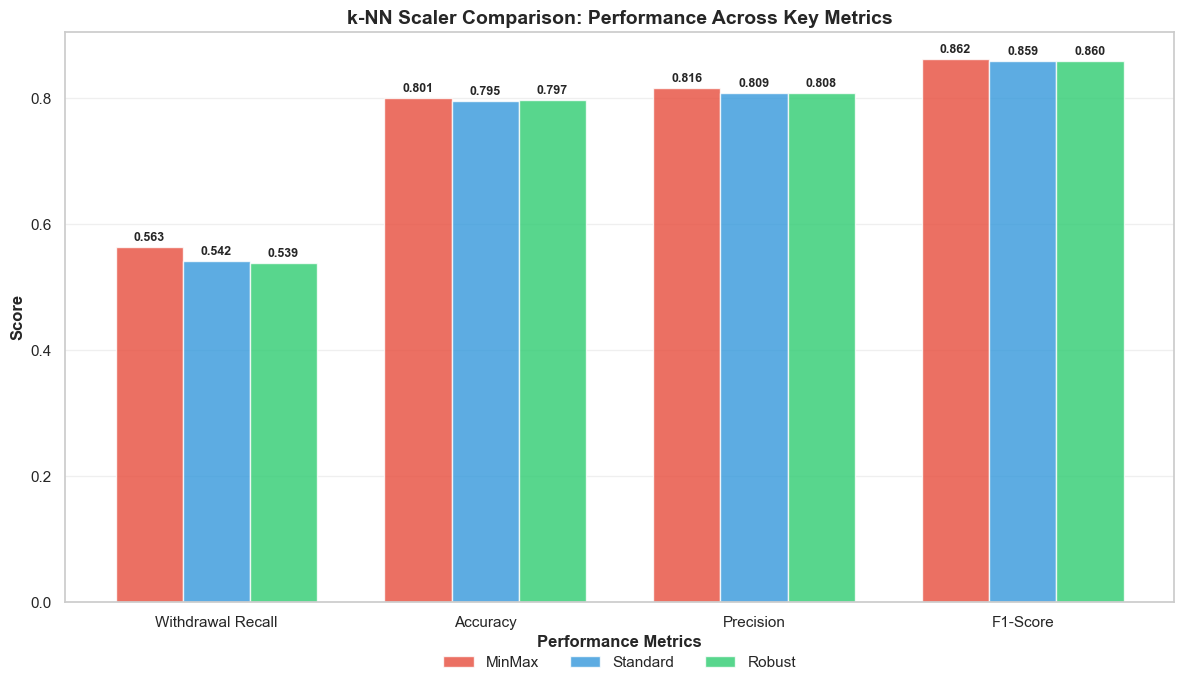


🏆 Winner: MinMax
Withdrawal Recall: 0.563
Improvement: +0.025


In [271]:
def test_different_scalers(X_train, X_test, y_train, y_test):
    """Test MinMax vs Standard vs Robust scalers to justify scaler choice."""
    
    sns.set_theme(style="whitegrid", palette="husl")
    
    # Define numeric columns for scaling
    numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                    'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                    'application_mode_withdrawal_rate']
    
    results = {}
    
    for name, scaler in [('MinMax', MinMaxScaler()), ('Standard', StandardScaler()), ('Robust', RobustScaler())]:
        
        # Create copies to avoid modifying originals
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        
        # Scale only numeric features
        X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_scaled[numeric_cols])
        X_test_scaled[numeric_cols] = scaler.transform(X_test_scaled[numeric_cols])
        
        # Simple k-NN with k=5
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        
        # Calculate key metrics
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            'Withdrawal Recall': withdrawal_recall,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1-Score': f1
        }
        
        print(f"{name}: Withdrawal Recall={withdrawal_recall:.3f}, Accuracy={accuracy:.3f}")
    
    # Create comparison chart
    df = pd.DataFrame(results).T
    
    fig, ax = plt.subplots(figsize=(12, 7))
    metrics = df.columns
    scalers = df.index
    x = np.arange(len(metrics))
    width = 0.25
    colors = ['#e74c3c', '#3498db', '#2ecc71']
    
    for i, (scaler, color) in enumerate(zip(scalers, colors)):
        offset = (i - 1) * width
        bars = ax.bar(x + offset, df.loc[scaler], width, label=scaler, color=color, alpha=0.8)
        
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('k-NN Scaler Comparison: Performance Across Key Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=3, frameon=False)
    ax.grid(True, axis='y', alpha=0.3)
    ax.grid(False, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Determine winner
    winner_scaler = df['Withdrawal Recall'].idxmax()
    print(f"\n🏆 Winner: {winner_scaler}")
    print(f"Withdrawal Recall: {df.loc[winner_scaler, 'Withdrawal Recall']:.3f}")
    print(f"Improvement: +{(df['Withdrawal Recall'].max() - df['Withdrawal Recall'].min()):.3f}")
    
    return df, winner_scaler

# Execute scaler comparison
scaler_results, best_scaler = test_different_scalers(X_train, X_test, y_train, y_test)

In [272]:
def define_column_groups(X_train):
    """Identify numeric and binary columns for preprocessing."""
    numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                    'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                    'application_mode_withdrawal_rate']

    binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
                   'parental_higher_education', 'parental_professional_occupation']
    
    # Verify columns exist in dataset
    missing_numeric = [col for col in numeric_cols if col not in X_train.columns]
    missing_binary = [col for col in binary_cols if col not in X_train.columns]
    
    if missing_numeric or missing_binary:
        print(f"❌ Missing columns - Numeric: {missing_numeric}, Binary: {missing_binary}")
        return None, None
    
    print(f"✅ Column groups defined:")
    print(f"- Numeric features: {len(numeric_cols)} columns")
    print(f"- Binary features: {len(binary_cols)} columns")
    
    return numeric_cols, binary_cols


In [273]:

def create_preprocessing_pipeline(knn_config, numeric_cols, binary_cols):
    """Create ColumnTransformer for preprocessing."""
    preprocessor = ColumnTransformer([
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler() if knn_config.get('scaler_type') == 'minmax' else StandardScaler())
        ]), numeric_cols),
        ('binary', 'passthrough', binary_cols)
    ], remainder='drop')
    
    scaler_type = knn_config.get('scaler_type', 'standard')
    print(f"✅ Preprocessing pipeline created with {scaler_type} scaling")
    
    return preprocessor


In [274]:

def create_complete_model_pipeline(preprocessor):
    """Create complete model pipeline with preprocessing, feature selection, and classifier."""
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
        ('classifier', KNeighborsClassifier())
    ])
    
    print("✅ Complete model pipeline created:")
    print("- Preprocessor: ColumnTransformer with scaling")
    print("- Feature selector: SelectKBest with mutual_info_classif")
    print("- Classifier: KNeighborsClassifier")
    
    return model_pipeline

# Execute pipeline design
numeric_cols, binary_cols = define_column_groups(X_train)
preprocessor = create_preprocessing_pipeline(knn_config, numeric_cols, binary_cols)
model_pipeline = create_complete_model_pipeline(preprocessor)

✅ Column groups defined:
- Numeric features: 6 columns
- Binary features: 4 columns
✅ Preprocessing pipeline created with minmax scaling
✅ Complete model pipeline created:
- Preprocessor: ColumnTransformer with scaling
- Feature selector: SelectKBest with mutual_info_classif
- Classifier: KNeighborsClassifier


In [275]:
def define_parameter_grid(knn_config):
    """Define hyperparameter search space for k-NN optimization."""
    k_min, k_max = knn_config['n_neighbors_range']
    
    param_grid = {
        'classifier__n_neighbors': list(range(k_min, k_max + 1)),
        'classifier__weights': ['uniform', 'distance'],
        'selector__k': ['all', 20, 40, 60]
    }
    
    print(f"✅ Parameter grid defined:")
    print(f"- n_neighbors: {k_min} to {k_max}")
    print(f"- weights: {param_grid['classifier__weights']}")
    print(f"- feature selection k: {param_grid['selector__k']}")
    
    return param_grid


In [276]:

def perform_grid_search(model_pipeline, param_grid, X_train, y_train):
    """Perform grid search with cross-validation using withdrawal recall scoring."""
    
    # Create withdrawal recall scorer (most important metric for early intervention)
    withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"🔍 Starting grid search:")
    print(f"- Scoring metric: withdrawal_recall (pos_label=0)")
    print(f"- CV folds: {inner_cv.n_splits}")
    print(f"- Total combinations: {len(param_grid['classifier__n_neighbors']) * len(param_grid['classifier__weights']) * len(param_grid['selector__k'])}")
    
    # Grid search with inner CV
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=withdrawal_recall_scorer,
        cv=inner_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"\n✅ Grid search completed!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score (withdrawal_recall): {grid_search.best_score_:.3f}")
    
    return grid_search


In [277]:

def train_final_model(grid_search):
    """Extract and return the trained model with optimal hyperparameters."""
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"✅ Final model trained with optimal hyperparameters:")
    print(f"- k_neighbors: {best_params['classifier__n_neighbors']}")
    print(f"- weights: {best_params['classifier__weights']}")
    print(f"- feature_selection: {best_params['selector__k']}")
    print(f"- CV withdrawal_recall: {best_score:.3f}")
    
    return best_model, best_params, best_score

# Execute hyperparameter tuning
param_grid = define_parameter_grid(knn_config)
grid_search = perform_grid_search(model_pipeline, param_grid, X_train, y_train)
best_model, best_params, best_cv_score = train_final_model(grid_search)

✅ Parameter grid defined:
- n_neighbors: 3 to 10
- weights: ['uniform', 'distance']
- feature selection k: ['all', 20, 40, 60]
🔍 Starting grid search:
- Scoring metric: withdrawal_recall (pos_label=0)
- CV folds: 5
- Total combinations: 64
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Grid search completed!
Best parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform', 'selector__k': 'all'}
Best CV score (withdrawal_recall): 0.682
✅ Final model trained with optimal hyperparameters:
- k_neighbors: 4
- weights: uniform
- feature_selection: all
- CV withdrawal_recall: 0.682


# 5. Evaluation

In [278]:
def evaluate_model_performance(best_model, X_test, y_test, class_names=None):
    """Comprehensive evaluation of k-NN model performance on test data."""
    
    if class_names is None:
        class_names = ['Withdrawn', 'Continuation']
    
    print('🔍 Evaluating k-NN model performance on test set...')
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of continuation
    
    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)  # Continuation recall
    withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)  # Withdrawal recall
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix analysis
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate specificity and sensitivity
    true_specificity = tn / (tn + fp)  # Correctly identified withdrawals
    sensitivity = tp / (tp + fn)  # Correctly identified continuations
    
    # Display results
    print(f'\n=== k-NN Model Performance ===')
    print(f'Test Samples: {len(y_test)}')
    print(f'Accuracy:     {accuracy:.3f}')
    print(f'Precision:    {precision:.3f}')
    print(f'Recall (Continuation): {recall:.3f}')
    print(f'Withdrawal Recall: {withdrawal_recall:.3f}')
    print(f'F1-Score:     {f1:.3f}')
    print(f'AUC-ROC:      {auc:.3f}')
    print(f'True Specificity: {true_specificity:.3f}')
    print(f'Sensitivity:  {sensitivity:.3f}')
    
    # Classification report
    print(f'\n=== Detailed Classification Report ===')
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Return comprehensive results
    results = {
        'model': best_model,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba,
        'actual': y_test,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'withdrawal_recall': withdrawal_recall,
        'f1_score': f1,
        'auc_roc': auc,
        'true_specificity': true_specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm,
        'class_names': class_names
    }
    
    return results


In [279]:

def plot_confusion_matrix_detailed(results, figsize=(10, 8)):
    """Plot confusion matrix with detailed labels and interpretation."""
    
    cm = results['confusion_matrix']
    class_names = results['class_names']
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Students'})
    
    plt.title('k-NN Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('Actual Class', fontsize=12)
    
    # Add detailed annotations
    labels = [['True Negative\n(TN)', 'False Positive\n(FP)'],
              ['False Negative\n(FN)', 'True Positive\n(TP)']]
    
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = cm[i, j]
            percentage = count / total * 100
            annotation = f'{labels[i][j]}\n{count}\n({percentage:.1f}%)'
            plt.text(j + 0.5, i + 0.5, annotation, 
                    ha='center', va='center', fontsize=11, 
                    fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    tn, fp, fn, tp = cm.ravel()
    print(f'\n📊 Confusion Matrix Interpretation:')
    print(f'True Negatives (Correctly predicted withdrawn):  {tn}')
    print(f'False Positives (Predicted continuation, actually withdrew): {fp}')
    print(f'False Negatives (Predicted withdrawal, actually continued): {fn}')
    print(f'True Positives (Correctly predicted continuation): {tp}')
    
    total_errors = fp + fn
    print(f'\n🔍 Key Insights:')
    print(f'Total Misclassifications: {total_errors} out of {total} ({total_errors/total*100:.1f}%)')
    print(f'More concerning errors: {"False Negatives" if fn > fp else "False Positives"} ({max(fn,fp)} students)')


In [280]:

def analyse_misclassifications(results, X_test):
    """Analyze misclassified students to understand model limitations."""
    
    y_pred = results['predictions']
    y_actual = results['actual']
    y_proba = results['prediction_probabilities']
    
    # Find misclassified samples
    misclassified_mask = y_pred != y_actual
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print('✅ No misclassifications found!')
        return pd.DataFrame()
    
    print(f'\n🔍 Analyzing {len(misclassified_indices)} misclassified students...')
    
    # Create analysis DataFrame
    misclassified_df = pd.DataFrame()
    misclassified_df['actual'] = y_actual[misclassified_mask]
    misclassified_df['predicted'] = y_pred[misclassified_mask]
    misclassified_df['prediction_confidence'] = np.abs(y_proba[misclassified_mask] - 0.5) + 0.5
    
    # Add feature values
    feature_names = X_test.columns.tolist()
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    for feature in feature_names:
        misclassified_df[feature] = X_test_df.iloc[misclassified_indices][feature].values
    
    # Categorize errors
    false_positives = misclassified_df[misclassified_df['actual'] == 0]
    false_negatives = misclassified_df[misclassified_df['actual'] == 1]
    
    print(f'❌ False Positives (predicted continuation, actually withdrew): {len(false_positives)}')
    print(f'❌ False Negatives (predicted withdrawal, actually continued): {len(false_negatives)}')
    
    # Confidence analysis
    low_confidence = misclassified_df[misclassified_df['prediction_confidence'] < 0.6]
    print(f'⚠️  Low confidence misclassifications (<60%): {len(low_confidence)}')
    
    # Add error type labels
    misclassified_df['error_type'] = misclassified_df['actual'].map({
        0: 'False Positive (Missed withdrawal)',
        1: 'False Negative (Predicted withdrawal incorrectly)'
    })
    
    return misclassified_df.sort_values('prediction_confidence')


🔍 Evaluating k-NN model performance on test set...

=== k-NN Model Performance ===
Test Samples: 885
Accuracy:     0.781
Precision:    0.839
Recall (Continuation): 0.839
Withdrawal Recall: 0.658
F1-Score:     0.839
AUC-ROC:      0.802
True Specificity: 0.658
Sensitivity:  0.839

=== Detailed Classification Report ===
              precision    recall  f1-score   support

   Withdrawn       0.66      0.66      0.66       284
Continuation       0.84      0.84      0.84       601

    accuracy                           0.78       885
   macro avg       0.75      0.75      0.75       885
weighted avg       0.78      0.78      0.78       885



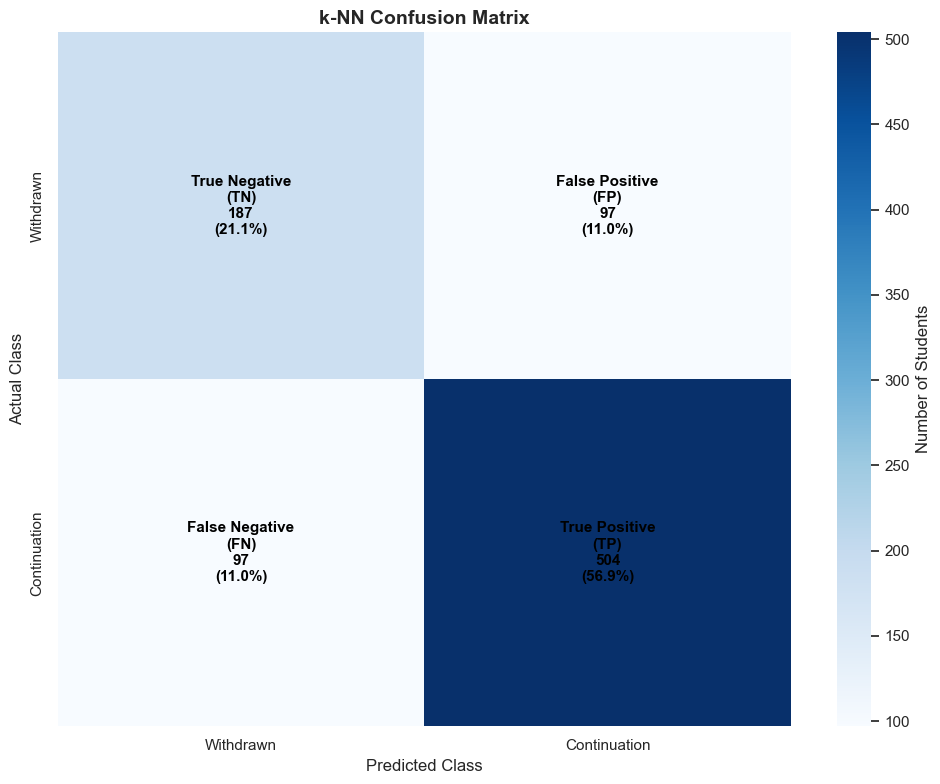


📊 Confusion Matrix Interpretation:
True Negatives (Correctly predicted withdrawn):  187
False Positives (Predicted continuation, actually withdrew): 97
False Negatives (Predicted withdrawal, actually continued): 97
True Positives (Correctly predicted continuation): 504

🔍 Key Insights:
Total Misclassifications: 194 out of 885 (21.9%)
More concerning errors: False Positives (97 students)

🔍 Analyzing 194 misclassified students...
❌ False Positives (predicted continuation, actually withdrew): 97
❌ False Negatives (predicted withdrawal, actually continued): 97
⚠️  Low confidence misclassifications (<60%): 71
📋 Model summary generated for reporting


In [281]:

def generate_model_summary(results, best_params, X_train):
    """Generate comprehensive model summary for reporting."""
    
    summary = {
        'model_type': 'k-Nearest Neighbours',
        'hyperparameters': {
            'k_neighbors': best_params['classifier__n_neighbors'],
            'weights': best_params['classifier__weights'],
            'feature_selection': best_params['selector__k']
        },
        'performance_metrics': {
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'withdrawal_recall': results['withdrawal_recall'],
            'f1_score': results['f1_score'],
            'auc_roc': results['auc_roc'],
            'true_specificity': results['true_specificity'],
            'sensitivity': results['sensitivity']
        },
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_samples': len(results['actual']),
        'feature_count': X_train.shape[1]
    }
    
    print("📋 Model summary generated for reporting")
    
    return summary

# Execute model evaluation
results = evaluate_model_performance(best_model, X_test, y_test)
plot_confusion_matrix_detailed(results)
misclassified_df = analyse_misclassifications(results, X_test)
model_summary = generate_model_summary(results, best_params, X_train)

# 6. Robustness Analysis

Starting comprehensive robustness analysis...
🔬 Testing model stability across 50 random seeds:
Seeds: [6490 9929 9815 2628 4709]...
Running... Done! ✅


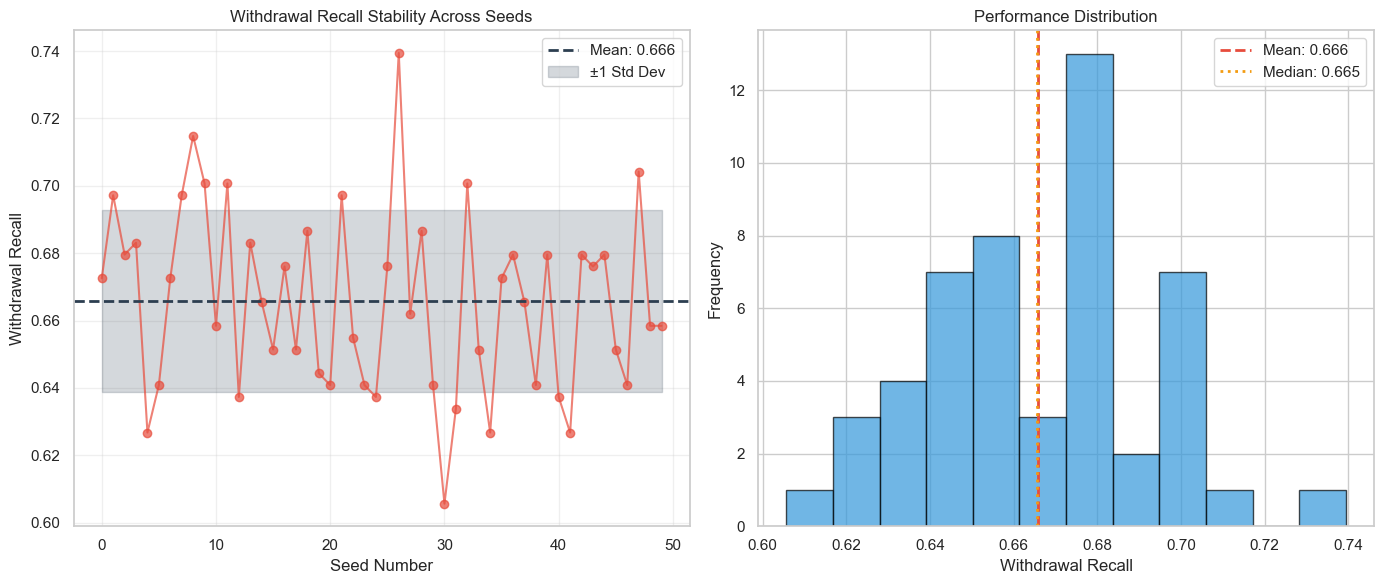

📊 Model Stability Analysis:
Mean withdrawal recall: 0.666 ± 0.027
Performance range: 0.606 to 0.739
Coefficient of variation: 0.041 (lower = more stable)
95% of results fall between: 0.627 and 0.712

            Metric  Value
0            Mean  0.666
1          Median  0.665
2         Std Dev  0.027
3             Min  0.606
4             Max  0.739
5           Range  0.134
6              CV  0.041
7              Q1  0.641
8              Q3  0.682
9             IQR  0.041
10  Most Common k      4


In [282]:
def test_model_stability_across_seeds(df_dataset, knn_config, best_scaler, n_seeds=50, use_fixed_seeds=False):
    """
    Test model stability across different random train/test splits.
    Ensures consistent performance for reliable deployment.
    """
    
    # Generate random seeds
    if use_fixed_seeds:
        np.random.seed(42)  # Reproducible seeds
    seeds = np.random.randint(1, 10000, n_seeds)
    
    print(f"🔬 Testing model stability across {n_seeds} random seeds:")
    print(f"Seeds: {seeds[:5]}{'...' if n_seeds > 5 else ''}")
    print("Running...", end=' ')
    
    results = []
    
    for seed in seeds:
        # Split data with current seed
        X = df_dataset.drop('target_binary', axis=1)
        y = df_dataset['target_binary']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.8, random_state=seed, stratify=y
        )
        
        # Apply withdrawal rate encoding (prevent leakage)
        def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col):
            train_df = X_train.copy()
            train_df['target_binary'] = y_train
            withdrawal_rates = train_df.groupby(categorical_col)['target_binary'].agg(['count', 'sum'])
            withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
            return withdrawal_rates['withdrawal_rate'].to_dict()
        
        course_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
        application_mode_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
        
        overall_withdrawal_rate = 1 - y_train.mean()
        
        X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
        X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)
        
        X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
        X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)
        
        X_test = X_test.fillna({
            'course_withdrawal_rate': overall_withdrawal_rate, 
            'application_mode_withdrawal_rate': overall_withdrawal_rate
        })
        
        X_train = X_train.drop(columns=['course', 'application_mode'])
        X_test = X_test.drop(columns=['course', 'application_mode'])
        
        # Create preprocessing pipeline
        numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                       'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                       'application_mode_withdrawal_rate']
        binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
                      'parental_higher_education', 'parental_professional_occupation']
        
        scaler_mapping = {'MinMax': MinMaxScaler(), 'Standard': StandardScaler(), 'Robust': RobustScaler()}
        selected_scaler = scaler_mapping.get(best_scaler, StandardScaler())
        
        preprocessor = ColumnTransformer([
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', selected_scaler)
            ]), numeric_cols),
            ('binary', 'passthrough', binary_cols)
        ], remainder='drop')
        
        # Create model pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
            ('classifier', KNeighborsClassifier())
        ])
        
        # Simple parameter grid for speed
        k_min, k_max = knn_config['n_neighbors_range']
        param_grid = {
            'classifier__n_neighbors': list(range(k_min, k_max + 1)),
            'classifier__weights': ['uniform']
        }
        
        # Grid search with withdrawal recall scoring
        withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring=withdrawal_recall_scorer, 
            cv=3, n_jobs=-1, verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = grid_search.predict(X_test)
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            'seed': seed,
            'best_k': grid_search.best_params_['classifier__n_neighbors'],
            'withdrawal_recall': withdrawal_recall,
            'accuracy': accuracy
        })
    
    print("Done! ✅")
    
    results_df = pd.DataFrame(results)
    return results_df

def plot_stability_results(results_df):
    """Visualize model stability across different random seeds."""
    
    plt.figure(figsize=(14, 6))
    
    # Performance variation plot
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results_df)), results_df['withdrawal_recall'], 'o-', alpha=0.7, color='#e74c3c')
    plt.axhline(results_df['withdrawal_recall'].mean(), color='#2c3e50', linestyle='--', linewidth=2,
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.fill_between(range(len(results_df)), 
                     results_df['withdrawal_recall'].mean() - results_df['withdrawal_recall'].std(),
                     results_df['withdrawal_recall'].mean() + results_df['withdrawal_recall'].std(),
                     alpha=0.2, color='#2c3e50', label=f'±1 Std Dev')
    plt.xlabel('Seed Number')
    plt.ylabel('Withdrawal Recall')
    plt.title('Withdrawal Recall Stability Across Seeds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Distribution histogram
    plt.subplot(1, 2, 2)
    plt.hist(results_df['withdrawal_recall'], bins=12, alpha=0.7, color='#3498db', edgecolor='black')
    plt.axvline(results_df['withdrawal_recall'].mean(), color='#e74c3c', linestyle='--', linewidth=2,
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.axvline(results_df['withdrawal_recall'].median(), color='#f39c12', linestyle=':', linewidth=2,
                label=f'Median: {results_df["withdrawal_recall"].median():.3f}')
    plt.xlabel('Withdrawal Recall')
    plt.ylabel('Frequency')
    plt.title('Performance Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_stability_metrics(results_df):
    """Calculate comprehensive stability metrics and summary."""
    
    wr = results_df['withdrawal_recall']
    
    stability_summary = pd.DataFrame({
        'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Range', 'CV', 'Q1', 'Q3', 'IQR', 'Most Common k'],
        'Value': [
            f"{wr.mean():.3f}",
            f"{wr.median():.3f}",
            f"{wr.std():.3f}", 
            f"{wr.min():.3f}",
            f"{wr.max():.3f}",
            f"{wr.max() - wr.min():.3f}",
            f"{wr.std()/wr.mean():.3f}",
            f"{wr.quantile(0.25):.3f}",
            f"{wr.quantile(0.75):.3f}",
            f"{wr.quantile(0.75) - wr.quantile(0.25):.3f}",
            f"{results_df['best_k'].mode().iloc[0]}"
        ]
    })
    
    print("📊 Model Stability Analysis:")
    print(f"Mean withdrawal recall: {wr.mean():.3f} ± {wr.std():.3f}")
    print(f"Performance range: {wr.min():.3f} to {wr.max():.3f}")
    print(f"Coefficient of variation: {wr.std()/wr.mean():.3f} (lower = more stable)")
    print(f"95% of results fall between: {wr.quantile(0.025):.3f} and {wr.quantile(0.975):.3f}")
    
    return stability_summary

# Execute robustness analysis
print("Starting comprehensive robustness analysis...")
stability_results = test_model_stability_across_seeds(df_dataset, knn_config, best_scaler, n_seeds=50)
plot_stability_results(stability_results)
stability_summary = calculate_stability_metrics(stability_results)
print("\n", stability_summary)